### Basic model:
Features: Income, Household composition, Property type
Predict installed pV (aggregation level: buurt, no time dependency) 

Income: CBS data '84799NED' (Kerncijfers wijken en buurten 2020)

In [1]:
# pip install cbsodata

In [2]:
import cbsodata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Read in (Kerncijfers wijken en buurten 2020
kerncijfers_2020 = '84799NED'
df_kerncijfers = pd.DataFrame(cbsodata.get_data(kerncijfers_2020))

Remove unusable items

In [4]:
df_kerncijfers = df_kerncijfers[df_kerncijfers['Codering_3'].isna() == False]

Keep only the data on Buurt level

In [5]:
#remove whitespaces from beginning and end of string column labels
df_kerncijfers = df_kerncijfers.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

is_buurt = df_kerncijfers['SoortRegio_2']=='Buurt'
df_kerncijfers = df_kerncijfers[is_buurt]

### Feature #1 - Income

Take a look at the number of buurten where the incomes are unknown

In [6]:
fraction_unfilled_incomes = df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna().sum()/ df_kerncijfers['GemiddeldInkomenPerInwoner_72'].sum() *100
print("Income not specified in: %.0f" % fraction_unfilled_incomes, "% of the buurten. Removing these entries.")

Income not specified in: 22 % of the buurten. Removing these entries.


<AxesSubplot:>

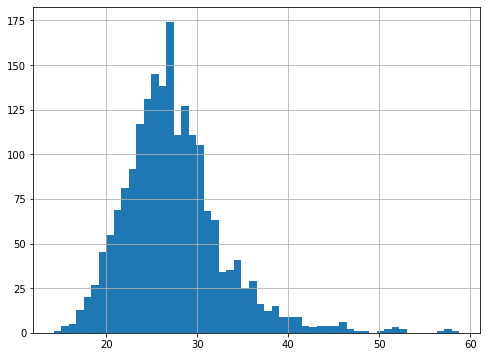

In [7]:
cutoff_income = 60
df_kerncijfers = df_kerncijfers[(df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna() == False)]

df_income_specified = df_kerncijfers[df_kerncijfers['GemiddeldInkomenPerInwoner_72'] < cutoff_income]
df_income_specified['GemiddeldInkomenPerInwoner_72'].hist(bins=54, figsize=(8, 6))

### Feature #2 - Household composition

In [8]:
fraction_unfilled_huishoudensgroottes = df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna().sum()/ df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].sum() *100

print("Average size of household not specified in: %.0f" % fraction_unfilled_huishoudensgroottes, "% of the buurten. Removing these entries.")

Average size of household not specified in: 0 % of the buurten. Removing these entries.


<AxesSubplot:>

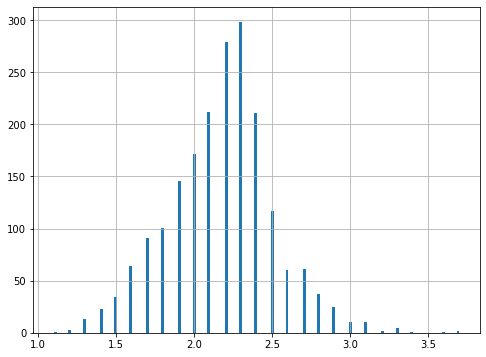

In [9]:
cut_off_household_size = 5
df_kerncijfers = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna() == False]

df_average_household_size_specified = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32']<cut_off_household_size]
df_average_household_size_specified['GemiddeldeHuishoudensgrootte_32'].hist(bins=140, figsize=(8, 6))

### Feature #3 - Percentage owned property (koopwoningen)

In [10]:
fraction_unfilled_owned_property_percentage = df_kerncijfers['Koopwoningen_40'].isna().sum()/ df_kerncijfers['Koopwoningen_40'].sum() *100

print("Average percentage of owned properties not specified in: %.0f" % fraction_unfilled_owned_property_percentage, "% of the buurten.")


Average percentage of owned properties not specified in: 0 % of the buurten.


Remove the 'BU' from the buurtcode and rename the column name so we can combine the datasets later

In [11]:
has_buurtcode_starting_with_BU = df_kerncijfers['Codering_3'].str.find('BU') == 0
buurtcodes_without_leading_BU = df_kerncijfers[has_buurtcode_starting_with_BU == False]
print("Number of buurten that don't start with 'BU': ", len(buurtcodes_without_leading_BU))

df_kerncijfers['CBS Buurtcode'] = pd.to_numeric(df_kerncijfers['Codering_3'].apply(lambda s:s.replace("BU","")))

Number of buurten that don't start with 'BU':  0


In [12]:
print("Duplicate buurtcodes: %.0f" % df_kerncijfers.duplicated(['CBS Buurtcode']).sum())
df_kerncijfers.astype({"CBS Buurtcode" : int})

Duplicate buurtcodes: 0


,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,AfstandTotSchool_108,ScholenBinnen3Km_109,OppervlakteTotaal_110,OppervlakteLand_111,OppervlakteWater_112,MeestVoorkomendePostcode_113,Dekkingspercentage_114,MateVanStedelijkheid_115,Omgevingsadressendichtheid_116,CBS Buurtcode
3,3,Annen,Aa en Hunze,Buurt,BU16800000,1,3460,1685,1775,540,...,0.8,2.6,252,252,0,9468,1.0,5.0,411.0,16800000
54,54,Gieten,Aa en Hunze,Buurt,BU16801700,1,4885,2360,2525,675,...,0.7,3.0,407,407,0,9461,1.0,4.0,520.0,16801700
62,62,Rolde,Aa en Hunze,Buurt,BU16801900,1,3770,1840,1930,470,...,0.9,1.0,333,333,0,9451,1.0,5.0,451.0,16801900
79,79,Centrum,Aalsmeer,Buurt,BU03580000,1,2785,1335,1445,365,...,0.5,3.0,61,54,7,1431,1.0,3.0,1070.0,3580000
80,80,Stommeer,Aalsmeer,Buurt,BU03580001,1,6535,3175,3360,955,...,0.8,3.2,192,184,8,1431,1.0,3.0,1205.0,3580001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,17324,Schellerlanden,Zwolle,Buurt,BU01935030,1,2610,1260,1345,355,...,0.3,13.3,74,72,2,8017,3.0,2.0,1687.0,1935030
17327,17327,Oldenelerbroek,Zwolle,Buurt,BU01935060,1,3305,1610,1695,500,...,0.6,11.9,80,76,4,8016,1.0,3.0,1491.0,1935060
17332,17332,Ittersumerlanden,Zwolle,Buurt,BU01935110,1,3860,1830,2025,615,...,0.6,11.7,50,48,2,8014,1.0,2.0,2063.0,1935110
17335,17335,Gerenlanden,Zwolle,Buurt,BU01935140,1,3065,1520,1545,575,...,0.5,12.1,58,55,2,8014,1.0,2.0,1940.0,1935140


## Target variable - opgesteld vermogen

Load the data from the Enexis supplied data file.

In [13]:
decentral_generation_072020 = './data/Enexis_decentrale_opwek_kv_(zon_pv)_01072020.csv'
df_decentral_generation = pd.read_csv(decentral_generation_072020,
                         sep                = ';',
                         decimal            = ',',
                         thousands          = '.',
                         encoding           = 'unicode_escape')        

Remove empty items

In [14]:
df_decentral_generation = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'].isna() == False]
df_decentral_generation = df_decentral_generation[df_decentral_generation['CBS Buurtcode'].isna() == False]

<AxesSubplot:>

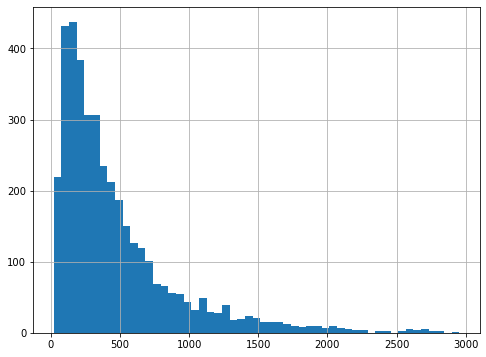

In [15]:
cut_off_generation = 3000

df_decentral_generation_specified = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'] < cut_off_generation]
df_decentral_generation_specified['Opgesteld vermogen'].hist(bins=53, figsize=(8, 6))

In [16]:
print("Duplicate buurtcodes: %.0f" % df_decentral_generation.duplicated(['CBS Buurtcode']).sum())
df_decentral_generation.astype({"CBS Buurtcode" : int})

Duplicate buurtcodes: 0


,ï»¿Peildatum,Netbeheerder,Provincie,Gemeente,CBS Buurt,CBS Buurtcode,Aantal aansluitingen in CBS-buurt,Aantal aansluitingen met opwekinstallatie,Opgesteld vermogen
0,202007.0,Enexis,Drenthe,Aa en Hunze,Annen,16800000,1491.0,447.0,1866.0
1,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Annen,16800009,116.0,29.0,243.0
2,202007.0,Enexis,Drenthe,Aa en Hunze,Eext,16800100,559.0,143.0,565.0
3,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Eext,16800109,127.0,24.0,150.0
4,202007.0,Enexis,Drenthe,Aa en Hunze,Anloo,16800200,127.0,29.0,129.0
...,...,...,...,...,...,...,...,...,...
4070,202007.0,Enexis,Overijssel,Zwolle,Gerenlanden,1935140,1218.0,323.0,992.0
4071,202007.0,Enexis,Overijssel,Zwolle,Gerenbroek,1935150,1217.0,315.0,949.0
4072,202007.0,Enexis,Overijssel,Zwolle,Oude Mars,1935160,59.0,19.0,127.0
4073,202007.0,Enexis,Overijssel,Zwolle,Windesheim,1935200,143.0,34.0,165.0


Check if the deduplication was successfull

### Combine the demographic data with the generation data

In [17]:
print("Number of rows in 'kerncijfers': %.0f" % len(df_kerncijfers))
print("Number of rows in 'generation data': %.0f" % len(df_decentral_generation))

df = pd.merge(df_kerncijfers, df_decentral_generation, on="CBS Buurtcode", validate='one_to_one')
print("Number of rows in combined data set: %.0f" % len(df))


Number of rows in 'kerncijfers': 1979
Number of rows in 'generation data': 3946
Number of rows in combined data set: 597


#### To do: check why not more rows match on buurt code

## Create a first model - linear model

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import altair as alt

In [20]:
opgesteld_vermogen = 'Opgesteld vermogen'
columns_to_keep = [opgesteld_vermogen, 'GemiddeldInkomenPerInwoner_72', 'GemiddeldeHuishoudensgrootte_32', 'Koopwoningen_40']
df = df[columns_to_keep]

train_set, test_set = train_test_split(df, test_size=0.2)

print(f"training set size: {len(train_set)}\ntest set size: {len(test_set)}")

Y_train_set = train_set[opgesteld_vermogen]
X_train_set = train_set.drop(opgesteld_vermogen, axis=1).copy()

Y_test_set = test_set[opgesteld_vermogen]
X_test_set = test_set.drop(opgesteld_vermogen, axis=1).copy()

lin_reg = LinearRegression()
lin_reg.fit(X_train_set, Y_train_set)

training set size: 477
test set size: 120


LinearRegression()

Plot the fit with income

In [21]:
alt.renderers.enable('mimetype')

base = alt.Chart(train_set).mark_circle().encode(
    alt.X('GemiddeldInkomenPerInwoner_72',
     title='# income'),
       alt.Y(opgesteld_vermogen,
     title='Opgesteld vermogen')
)

linear_fit = [
    base.transform_regression(
        "GemiddeldInkomenPerInwoner_72", opgesteld_vermogen, method="linear"
    )
    .mark_line()   
]

alt.layer(base, *linear_fit)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


#### Check the quality of the model

In [22]:
# Make predictions using the testing set
y_pred = lin_reg.predict(X_test_set)

# The coefficients
print("Coefficients: \n", lin_reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test_set, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test_set, y_pred))

Coefficients: 
 [ -23.44659621 -262.17359744   23.36871748]
Mean squared error: 639786.93
Coefficient of determination: 0.16


## Create a first model - tree model

In [23]:
from sklearn.tree import DecisionTreeRegressor

Create helper class

In [24]:
class Result:
  def __init__(self, r_squared, mean_squared_error):
    self.r_squared = r_squared
    self.mean_squared_error = mean_squared_error

In [36]:
results = {}

max_range = 10

# Fit regression models
for i in range(1, max_range):
    r = DecisionTreeRegressor(max_depth=i, random_state=3)
    r.fit(X_train_set, Y_train_set)
    y_predict = r.predict(X_test_set)
    results[i] = Result(r2_score(Y_test_set, y_predict), mean_squared_error(Y_test_set, y_predict)) 

#### Check the quality of the models

In [38]:
for i in range(1,max_range):
    print("Depth  %2.f" % i, ":R squared: %.2f" % results[i].r_squared,
    "-- Mean squared error: %.0f" % results[i].mean_squared_error)


Depth   1 :R squared: 0.17 -- Mean squared error: 629679
Depth   2 :R squared: 0.19 -- Mean squared error: 619965
Depth   3 :R squared: 0.19 -- Mean squared error: 615368
Depth   4 :R squared: 0.18 -- Mean squared error: 624610
Depth   5 :R squared: 0.16 -- Mean squared error: 642913
Depth   6 :R squared: 0.21 -- Mean squared error: 601944
Depth   7 :R squared: 0.14 -- Mean squared error: 657660
Depth   8 :R squared: 0.15 -- Mean squared error: 649468
Depth   9 :R squared: 0.02 -- Mean squared error: 747040


Best performance is at depth = 2 (Not the same over runs &#9785; though)

In [27]:
optimum_depth = 2
print("Depth  %2.f" % optimum_depth, ":R squared: %.2f" % results[optimum_depth].r_squared,
    "-- Mean squared error: %.0f" % results[optimum_depth].mean_squared_error)

Depth   2 :R squared: 0.19 -- Mean squared error: 619965
